#### Conda debug

In [1]:
#!conda info

In [2]:
#!which jupyter

In [3]:
#!which jupyter-lab

In [4]:
#!jupyter-troubleshoot

In [5]:
# get formating done automatically according to style `black`
%load_ext lab_black

#### get resources

In [3]:
from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)

Number of CPUs: 48, number of threads: 6, number of workers: 8


In [4]:
client = Client(
    processes=False, threads_per_worker=threads, n_workers=nworker, memory_limit="256GB"
)
client

/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40026 instead
  http_address["port"], self.http_server.port


<Client: 'inproc://10.50.40.137/15366/21' processes=8 threads=48, memory=515.40 GB>

If you want to use the `dask labextension dashboard`, please install you own conda and then intake-esm.

# Intake to load CMIP data

### Using intake-esm on mistral

- install intake-esm: https://intake-esm.readthedocs.io/en/latest/installation.html
- check the already built catalogs: `/work/ik1017/Catalogs` or `https://github.com/NCAR/intake-esm-datastore/` or `https://gitlab.dkrz.de/mipdata/intake-esm` and skip long catalog building process of building `builders/*.ipynb`

Available catalogs:
- CMIP6: `/work/ik1017/Catalogs/mistral-cmip6.json`
- CMIP5: `/work/ik1017/Catalogs/mistral-cmip5.json`
- MPI Grand Ensemble: `/work/ik1017/Catalogs/mistral-MPI-GE.json`

In [5]:
# available catalogs: combination of .json and .csv
!ls /work/ik1017/Catalogs/

archive		      mistral-cmip6.json     mistral-MPI-GE.json
mistral-cmip5.csv.gz  mistral-miklip.csv.gz  ncar-intake-esm-datastore
mistral-cmip5.json    mistral-miklip.json    pangeo-cmip6.json
mistral-cmip6.csv.gz  mistral-MPI-GE.csv.gz


---
You may see some warnings below. About tornado and bokeh. I will try to fix this. This does not happen when taking the default `-p shared`, but then we often have too little memory for the analysis. Therefore, I recommend for now using `-p compute`

---

In [6]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

%matplotlib inline

In [7]:
# if the warnings bother you
# import warnings
# warnings.simplefilter("ignore")

In [8]:
# should be >= 2019.12.13
import intake_esm

intake_esm.__version__

'2020.5.1'

# CMIP6

In [9]:
# json file contains the rules for concat and merge as well as the location for the catalog .csv file
col_url = "/work/ik1017/Catalogs/mistral-cmip6.json"

In [10]:
#!cat /work/ik1017/Catalogs/mistral-cmip6.json

In [11]:
col = intake.open_esm_datastore(col_url)

# col.df is a pandas.DataFrame: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame
col.df.head()

activity_id     institution_id        source_id   experiment_id member_id  \
0  AerChemMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM  ssp370-lowNTCF  r1i1p1f1   
1  AerChemMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM  ssp370-lowNTCF  r1i1p1f1   
2  AerChemMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM  ssp370-lowNTCF  r1i1p1f1   
3  AerChemMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM  ssp370-lowNTCF  r1i1p1f1   
4  AerChemMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM  ssp370-lowNTCF  r1i1p1f1   

  table_id variable_id grid_label  dcpp_init_year    version     time_range  \
0     Lmon         npp         gn             NaN  v20190627  203501-205412   
1     Lmon         npp         gn             NaN  v20190627  201501-203412   
2     Lmon         npp         gn             NaN  v20190627  205501-205512   
3     Lmon         tsl         gn             NaN  v20190627  205501-205512   
4     Lmon         tsl         gn             NaN  v20190627  201501-203412   

                                                path  
0  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...  
1  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...  
2  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...  
3  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...  
4  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...

In [15]:
# overview of available keys and accepted values
uni_dict = col.unique(["source_id", "institution_id", "table_id", "experiment_id"])
# pprint.pprint(uni_dict, compact=True)

In [16]:
# quick check by hand
# col.df.source_id.unique()

## GMST MPI-ESM-LR plot

In [17]:
# col.search selects the experiments you specify in `query`
variable = "tas"
query = dict(
    experiment_id="historical",
    table_id="Amon",
    member_id="r1i1p1f1",
    variable_id=variable,
    source_id="MPI-ESM1-2-LR",
)
cat = col.search(**query)
cat.df.head()

activity_id institution_id      source_id experiment_id member_id table_id  \
0        CMIP          MPI-M  MPI-ESM1-2-LR    historical  r1i1p1f1     Amon   
1        CMIP          MPI-M  MPI-ESM1-2-LR    historical  r1i1p1f1     Amon   
2        CMIP          MPI-M  MPI-ESM1-2-LR    historical  r1i1p1f1     Amon   
3        CMIP          MPI-M  MPI-ESM1-2-LR    historical  r1i1p1f1     Amon   
4        CMIP          MPI-M  MPI-ESM1-2-LR    historical  r1i1p1f1     Amon   

  variable_id grid_label  dcpp_init_year    version     time_range  \
0         tas         gn             NaN  v20190710  189001-190912   
1         tas         gn             NaN  v20190710  201001-201412   
2         tas         gn             NaN  v20190710  195001-196912   
3         tas         gn             NaN  v20190710  197001-198912   
4         tas         gn             NaN  v20190710  187001-188912   

                                                path  
0  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...  
1  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...  
2  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...  
3  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...  
4  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...

In [18]:
# this gets xr.Datasets from netcdf files with `dask`
dset_dict = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": 12 * 50}})
# show the list of available xr.Datasets
list(dset_dict)

Dataset(s):   0%|                                        | 0/1 [00:00<?, ?it/s]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Dataset(s): 100%|████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]


['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn']

In [19]:
# get first item
_, ds = dset_dict.popitem()
# extract xr.dataArray
da = ds[variable].squeeze()

# lazy data
da.data

dask.array<getitem, shape=(1980, 96, 192), dtype=float32, chunksize=(240, 96, 192), chunktype=numpy.ndarray>

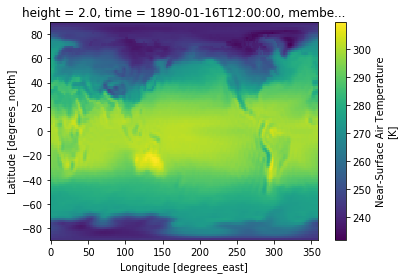

In [20]:
# weird is that .isel(time=0) is not 1850
da.isel(time=0).plot()

In [16]:
def yearmean(ds, dim="time"):
    return ds.groupby(f"{dim}.year").mean().rename({"year": dim})

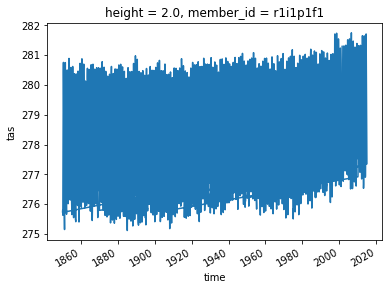

In [17]:
da.mean(["lon", "lat"]).plot()

In [ ]:
yearmean(da).mean(["lon", "lat"]).plot()

## multiple models
now SST

In [ ]:
variable = "tos"
query = dict(
    experiment_id="historical",
    table_id="Omon",
    member_id="r1i1p1f1",
    variable_id=variable,
    grid_label="gn",
)
cat = col.search(**query)
# subselect a few models
models = list(cat.df.source_id.unique())[::5]
print(f"models choosen: {models}")
# refine search for these models
cat = cat.search(source_id=models)
cat.df.head()

In [ ]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": 12 * 50}})
list(dset_dict)

In [ ]:
model_list = []
da_list = []
for key, value in dset_dict.items():
    print(key, dset_dict[key][variable].coords)
    da = dset_dict[key][variable].squeeze()
    display(da.data,'\n')
    spatial_dims = [dim for dim in da.dims if dim != "time"]
    da_gm = da.mean(spatial_dims)
    # setting time identical
    da_gm = da_gm.sortby("time")
    da_gm["time"] = xr.cftime_range(start="1850", freq="MS", periods=da_gm.time.size)
    ## witch memory issues or in debugging you may want to trigger computation here
    # da_gm = da_gm.compute()
    da_list.append(da_gm)
    model = key.split(".")[2]
    model_list.append(model)

In [ ]:
da = xr.concat(da_list, dim="model")
da["model"] = model_list

In [ ]:
da = da.load()

In [ ]:
# annual means
da_ym = yearmean(da)

In [ ]:
da_ym.plot(hue="model")
plt.title("GMOST")

In [ ]:
start, end = 1960, 1990
da_ym_anom = da_ym - da_ym.sel(time=slice(start, end)).mean("time")

In [ ]:
da_ym_anom.plot(hue="model")
for x in [start, end]:
    plt.axvline(x=x, c="k", ls=":")
plt.axhline(y=0, c="k", ls="--")
plt.title(f"GMOST Anomaly with respect to {start}-{end}")
plt.show()

## many experiments all having the same model available

Imagine you want to check whether GMST has different variability when CO$_2$ is prescribed (`piControl`) or prognostic (`esm-piControl`). So you only find models which provide output for both simulations.

`require_all_on` is your friend.

In [41]:
query = dict(
    experiment_id=["esm-piControl", "piControl"],
    require_all_on="source_id",
    variable_id="tas",
    table_id="Amon",
)
cat = col.search(**query)
cat.df.head()

activity_id institution_id      source_id  experiment_id member_id table_id  \
0        CMIP          CSIRO  ACCESS-ESM1-5  esm-piControl  r1i1p1f1     Amon   
1        CMIP          CSIRO  ACCESS-ESM1-5  esm-piControl  r1i1p1f1     Amon   
2        CMIP          CSIRO  ACCESS-ESM1-5      piControl  r1i1p1f1     Amon   
3        CMIP          CSIRO  ACCESS-ESM1-5      piControl  r1i1p1f1     Amon   
4        CMIP            BCC    BCC-CSM2-MR  esm-piControl  r1i1p1f1     Amon   

  variable_id grid_label  dcpp_init_year    version     time_range  \
0         tas         gn             NaN  v20191115  057101-077012   
1         tas         gn             NaN  v20191115  027101-057012   
2         tas         gn             NaN  v20191214  060101-100012   
3         tas         gn             NaN  v20191214  010101-060012   
4         tas         gn             NaN  v20181114  185001-214912   

                                                path  
0  /work/ik1017/CMIP6/data/CMIP6/CMIP/CSIRO/ACCES...  
1  /work/ik1017/CMIP6/data/CMIP6/CMIP/CSIRO/ACCES...  
2  /work/ik1017/CMIP6/data/CMIP6/CMIP/CSIRO/ACCES...  
3  /work/ik1017/CMIP6/data/CMIP6/CMIP/CSIRO/ACCES...  
4  /work/ik1017/CMIP6/data/CMIP6/CMIP/BCC/BCC-CSM...

In [42]:
cat.df.source_id.unique()

array(['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-ESM2-1', 'CanESM5',
       'GFDL-ESM4', 'NorESM2-LM', 'UKESM1-0-LL'], dtype=object)

## advanced

### spatial plotting

On ocean grid there are all sorts of dimension and coordinate names: `(i,j)`, `(x,y)`, `(xc,yc)`, `(lon,lat)`.

`cmip6_preprocessing` tries to correct many of these inhomogenities. Particularly useful for (ocean) multi-model comparisons.

Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [ ]:
import cartopy.crs as ccrs
import cartopy as cp

In [ ]:
variable = "fgco2"
query = dict(experiment_id="esm-piControl", table_id="Omon", variable_id=variable)
cat = col.search(**query)
cat.df.head()

In [11]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

# combined_preprocessing??

In [ ]:
dset_dict = cat.to_dataset_dict(
    cdf_kwargs={"chunks": {"time": 12 * 100}, "use_cftime": True},
    preprocess=combined_preprocessing,
)
list(dset_dict)

Processing CMIP.CCCma.CanESM5.esm-piControl.Omon.gn


/work/bm1124/m300524/conda-envs/intake-esm/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Processing CMIP.CNRM-CERFACS.CNRM-ESM2-1.esm-piControl.Omon.gn


/work/bm1124/m300524/conda-envs/intake-esm/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Processing CMIP.CSIRO.ACCESS-ESM1-5.esm-piControl.Omon.gn


/work/bm1124/m300524/conda-envs/intake-esm/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Processing CMIP.NCAR.CESM2.esm-piControl.Omon.gn


/work/bm1124/m300524/conda-envs/intake-esm/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Processing CMIP.NCAR.CESM2.esm-piControl.Omon.gr


/work/bm1124/m300524/conda-envs/intake-esm/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Processing CMIP.NOAA-GFDL.GFDL-ESM4.esm-piControl.Omon.gr


/work/bm1124/m300524/conda-envs/intake-esm/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


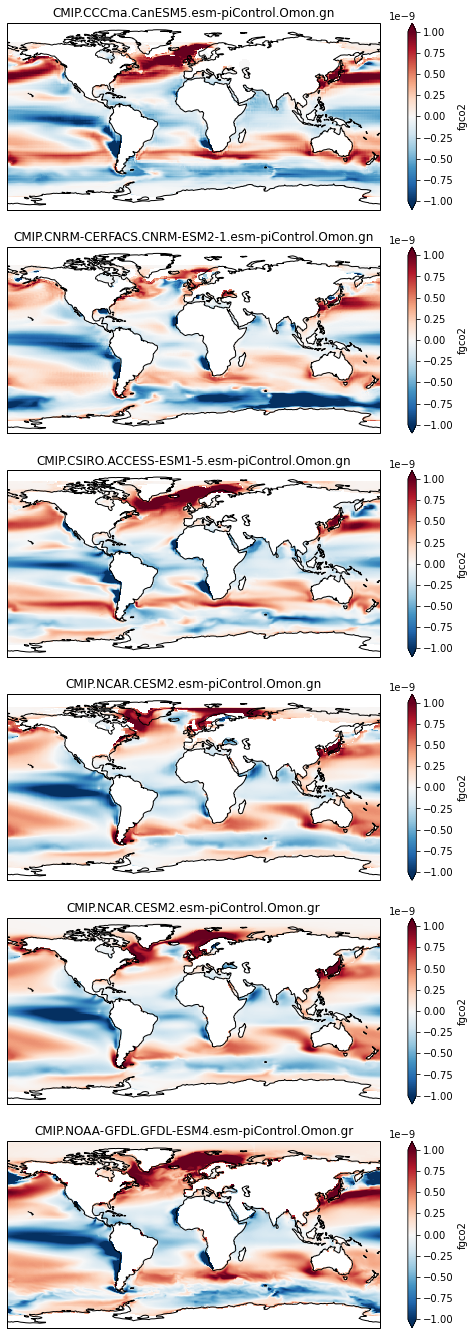

In [58]:
fig, axarr = plt.subplots(
    nrows=len(dset_dict),
    figsize=[10, 4 * len(dset_dict)],
    subplot_kw={"projection": ccrs.PlateCarree()},
)
for ax, (k, ds) in zip(axarr.flat, dset_dict.items()):
    print(f"Processing {k}")
    # do your science here
    ds = ds.mean("time")
    assert len(ds[variable].squeeze().dims) == 2
    ds[variable].squeeze().plot(
        ax=ax,
        robust=True,
        transform=ccrs.PlateCarree(),
        vmin=-1e-9,
        vmax=1e-9,
        cmap="RdBu_r",
    )
    # visuals
    ax.set_title(k)
    ax.set_global()
    ax.coastlines()
    # ax.add_feature(cp.feature.LAND)

## regrid

In [12]:
variable = "tos"
query = dict(experiment_id="piControl", table_id="Omon", variable_id=variable)
cat = col.search(**query)

In [14]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
dset_dict = cat.to_dataset_dict(
    cdf_kwargs={"chunks": {"time": 12 * 100}, "use_cftime": True},
    preprocess=combined_preprocessing,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Dataset(s):   0%|                                       | 0/57 [00:00<?, ?it/s]/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
Dataset(s):   4%|█                              | 2/57 [00:07<03:33,  3.89s/it]/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/cmip6_preprocessing/preprocessing.py:231: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
Dataset(s):   7%|██▏    

In [15]:
import xesmf as xe

def regrid(ds, deg=1, **kwargs):
    ds_out = xe.util.grid_global(deg, deg)
    regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True, **kwargs)
    ds_out = regridder(ds)
    return ds_out

In [16]:
# some models dont need transpose: NCAR CESM2

CMIP.EC-Earth-Consortium.EC-Earth3-LR.piControl.Omon.gn
transpose to x y
Coordinates:
    lon        (x, y) float32 1.596405 1.5007324 1.4110413 ... 71.75726 74.24272
    lat        (x, y) float32 -77.88607 -77.702934 ... 80.35165 80.35165
  * y          (y) float32 -77.98098 -77.787895 -77.592094 ... 89.74177 90.0
    time       object 1991-01-16 12:00:00
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    member_id  <U8 'r1i1p1f1' (362, 292) ('x', 'y')


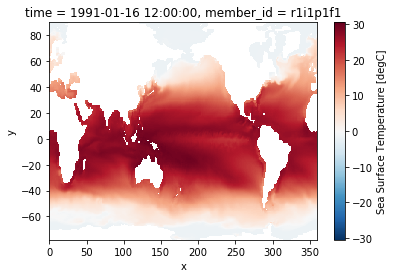

/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: bilinear_362x292_180x360.nc
CMIP.EC-Earth-Consortium.EC-Earth3-LR.piControl.Omon.gn ESMC_FieldRegridStoreFile() failed with rc = 506.    Please check the log files (named "*ESMF_LogFile").
try to show lon lat


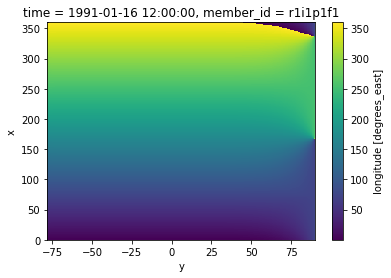

In [ ]:
model = list(dset_dict)[2]
#model = 'CMIP.NASA-GISS.GISS-E2-1-G-CC.piControl.Omon.gn'
#model = 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.Omon.gn'
model = models_fail[4]
print(model)
#periodic=True if model in ['CMIP.NASA-GISS.GISS-E2-1-G-CC.piControl.Omon.gn'] else False
ds = dset_dict[model].isel(time=0)[variable].squeeze()
if 'member_id' in ds.dims:
    ds=ds.isel(member_id=0)
# print(ds.load().coords,ds.shape,ds.dims)
if ds.dims != ('x', 'y'):
    ds = ds.transpose('x','y', ..., transpose_coords=True)
    print('transpose to x y')
print(ds.load().coords,ds.shape,ds.dims)
ds.plot(x='x')
plt.show()
try:
    dsr=regrid(ds)
    dsr.plot()
except ValueError as ve: #ESMC_FieldRegridStoreFile() failed with rc = 506.    Please check the log files (named "*ESMF_LogFile").
    print(model,ve)
    try:
        print('try to show lon lat')
        for d in ['lon','lat']:
            ds[d].plot()
            plt.show()
    except:
        pass

In [18]:
models_success=[]
models_fail = []
for key in dset_dict:
    model = key.split('.')[2]
    print(model,key)
    ds = dset_dict[key]
    # sel dataarray
    ds = ds.isel(time=0)[variable].squeeze()
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    try:
        if ds.dims != ('x', 'y'):
            ds = ds.transpose('x','y', ..., transpose_coords=True)
        dsr = regrid(ds)
        dsr.plot()
        plt.show()
        models_success.append(key)
    except Exception as e:
        print('regridding error',e)
        models_fail.append(key)
        try:
            ds['lon'].plot()
            plt.show()
        except:
            pass
    print(ds.load().coords)
    print('\n\n')

In [21]:
print('models_fail: ',models_fail)

models_fail:  ['CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.Omon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.piControl.Omon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.Omon.gn', 'CMIP.AWI.AWI-ESM-1-1-LR.piControl.Omon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-LR.piControl.Omon.gn', 'CMIP.AWI.AWI-CM-1-1-MR.piControl.Omon.gn', 'CMIP.NUIST.NESM3.piControl.Omon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.piControl.Omon.gn', 'CMIP.NCC.NorESM1-F.piControl.Omon.gn', 'CMIP.MOHC.HadGEM3-GC31-MM.piControl.Omon.gn', 'CMIP.NCC.NorESM2-MM.piControl.Omon.gn', 'CMIP.NCC.NorESM2-LM.piControl.Omon.gn', 'CMIP.MPI-M.MPI-ESM1-2-HR.piControl.Omon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.Omon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3.piControl.Omon.gn']


In [22]:
print('models_success: ',models_success)

models_success:  ['CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.Omon.gr1', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.Omon.gr1', 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Omon.gn', 'CMIP.BCC.BCC-CSM2-MR.piControl.Omon.gn', 'CMIP.CSIRO.ACCESS-ESM1-5.piControl.Omon.gn', 'CMIP.CAMS.CAMS-CSM1-0.piControl.Omon.gn', 'CMIP.BCC.BCC-ESM1.piControl.Omon.gn', 'CMIP.MRI.MRI-ESM2-0.piControl.Omon.gr', 'CMIP.CAS.FGOALS-f3-L.piControl.Omon.gn', 'CMIP.MRI.MRI-ESM2-0.piControl.Omon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.piControl.Omon.gn', 'CMIP.NCC.NorCPM1.piControl.Omon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.piControl.Omon.gn', 'CMIP.MIROC.MIROC-ES2L.piControl.Omon.gn', 'CMIP.FIO-QLNM.FIO-ESM-2-0.piControl.Omon.gn', 'CMIP.UA.MCM-UA-1-0.piControl.Omon.gn', 'CMIP.NCAR.CESM2-WACCM.piControl.Omon.gn', 'CMIP.CCCma.CanESM5.piControl.Omon.gn', 'CMIP.NASA-GISS.GISS-E2-2-G.piControl.Omon.gn', 'CMIP.NCAR.CESM2-WACCM.piControl.Omon.gr', 'CMIP.THU.CIESM.piControl.Omon.gn', 'CMIP.NCAR.CESM2-FV2.piControl.Omon.gn', 'CMIP.NCAR.CESM2-W

# using different experiments
currently there are catalogs for these multi-simulation initiatives available for `mistral`:
- CMIP6
- CMIP5
- MiKlip
- GrandEnsemble

## CMIP5

In [59]:
col_url = "/work/ik1017/Catalogs/mistral-cmip5.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

product_id institute       model  experiment frequency modeling_realm  \
0    output1      MOHC  HadGEM2-CC  historical       day          atmos   
1    output1      MOHC  HadGEM2-CC  historical       day          atmos   
2    output1      MOHC  HadGEM2-CC  historical       day          atmos   
3    output1      MOHC  HadGEM2-CC  historical       day          atmos   
4    output1      MOHC  HadGEM2-CC  historical       day          atmos   

  mip_table ensemble_member variable    temporal_subset    version  \
0       day          r2i1p1      rhs  19991201-20041130  v20111129   
1       day          r2i1p1      rhs  20041201-20051130  v20111129   
2       day          r2i1p1      rhs  19791201-19841130  v20111129   
3       day          r2i1p1      rhs  19591201-19641130  v20111129   
4       day          r2i1p1      rhs  19841201-19891130  v20111129   

                                                path  
0  /work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...  
1  /work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...  
2  /work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...  
3  /work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...  
4  /work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...

In [60]:
uni_dict = col.unique(["model", "institute", "mip_table", "experiment", "variable"])
pprint.pprint(uni_dict, compact=True)

{'experiment': {'count': 101,
                'values': ['historical', 'piControl', 'rcp85', 'midHolocene',
                           'rcp45', 'amip4K', 'aqua4xCO2', 'sstClim',
                           'sstClimAerosol', 'sstClimSulfate', 'amip4xCO2',
                           'amip', 'sstClim4xCO2', 'aqua4K', 'aquaControl',
                           'amipFuture', 'decadal2001', 'decadal1982',
                           'decadal1961', 'decadal2003', 'decadal1973',
                           'decadal1963', 'decadal1975', 'decadal1996',
                           'decadal2005', 'decadal2000', 'decadal1988',
                           'decadal2002', 'decadal1972', 'decadal1977',
                           'decadal2008', 'decadal1986', 'decadal1968',
                           'decadal1999', 'decadal1967', 'decadal1992',
                           'decadal1990', 'decadal1978', 'decadal1960',
                           'decadal1984', 'decadal1976', 'decadal1980',
                       

In [61]:
variable = "fgco2"
dset_dict = col.search(experiment="esmControl", variable=variable).to_dataset_dict(
    cdf_kwargs={"chunks": {"time": 12 * 50}, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'
                
--> There is/are 14 group(s)


In [62]:
# example: take a single dataset out of dict
ds = dset_dict["MPI-M.MPI-ESM-LR.esmControl.Omon"]["fgco2"].squeeze()  # .load()

In [63]:
ds.coords

Coordinates:
    lon              (j, i) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
    lat              (j, i) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * time             (time) object 2600-01-16 12:00:00 ... 2349-12-16 12:00:00
  * j                (j) int32 1 2 3 4 5 6 7 8 ... 214 215 216 217 218 219 220
  * i                (i) int32 1 2 3 4 5 6 7 8 ... 250 251 252 253 254 255 256
    ensemble_member  <U6 'r1i1p1'

## MiKlip
MiKlip data is cmorized based on `CMIP5` conventions.
The following catalog `col` contains output from 5 `generation`s of MiKlip output from `/work/bmx828/miklip-ces/data4miklip/model/global/miklip/`.

Beware: Unfortunately, these experiments use different names for experiment naming (probably more columns).

- Marotzke, Jochem, Wolfgang A. Müller, Freja S. E. Vamborg, Paul Becker, Ulrich Cubasch, Hendrik Feldmann, Frank Kaspar, et al. “MiKlip: A National Research Project on Decadal Climate Prediction.” Bulletin of the American Meteorological Society 97, no. 12 (June 17, 2016): 2379–94. https://doi.org/10/gddfck.


In [64]:
col_url = "/work/ik1017/Catalogs/mistral-miklip.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

generation product_id institute       model   experiment frequency  \
0  baseline0    output1     MPI-M  MPI-ESM-LR  decadal2001       day   
1  baseline0    output1     MPI-M  MPI-ESM-LR  decadal2001       day   
2  baseline0    output1     MPI-M  MPI-ESM-LR  decadal2001       day   
3  baseline0    output1     MPI-M  MPI-ESM-LR  decadal2001       day   
4  baseline0    output1     MPI-M  MPI-ESM-LR  decadal2001       day   

  modeling_realm mip_table ensemble_member variable    temporal_subset  \
0          atmos       day          r2i1p1  sfcWind  20020101-20111231   
1          atmos       day          r2i1p1      tas  20020101-20111231   
2          atmos       day          r2i1p1      psl  20020101-20111231   
3          atmos       day          r2i1p1       pr  20020101-20111231   
4          atmos       day          r2i1p1   tasmin  20020101-20111231   

     version                                               path  
0  v20111122  /work/bmx828/miklip-ces/data4miklip/model/glob...  
1  v20111122  /work/bmx828/miklip-ces/data4miklip/model/glob...  
2  v20111122  /work/bmx828/miklip-ces/data4miklip/model/glob...  
3  v20111122  /work/bmx828/miklip-ces/data4miklip/model/glob...  
4  v20111122  /work/bmx828/miklip-ces/data4miklip/model/glob...

In [65]:
col.df.nunique()

generation               6
product_id               4
institute                4
model                    5
experiment             402
frequency                8
modeling_realm           7
mip_table               21
ensemble_member         93
variable               276
temporal_subset       2727
version                 22
path               1773282
dtype: int64

In [66]:
import pprint

uni_dict = col.unique(["generation", "product_id"])
pprint.pprint(uni_dict, compact=True)

{'generation': {'count': 7,
                'values': ['baseline0', 'baseline1', 'preop-dcpp', nan, 'preop',
                           'miklip', 'prototype']},
 'product_id': {'count': 5,
                'values': ['output1', 'output', 'miklip-extra', nan, 'preop']}}


In [67]:
# example: comparing inits from 1991 from two generations
cat = col.search(
    model="MPI-ESM-LR",
    variable="tas",
    frequency="mon",
    ensemble_member=["r1i1p1", "r2i1p1", "r3i1p1"],
    experiment=["decs4e1991", "decs4e1992", "decadal1991", "decadal1992"],
)

In [68]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": 12 * 5}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'
                
--> There is/are 4 group(s)


In [69]:
ds = xr.concat(
    [i["tas"].squeeze().mean("ensemble_member") for i in dset_dict.values()], "run"
)
ds["run"] = list(dset_dict.keys())

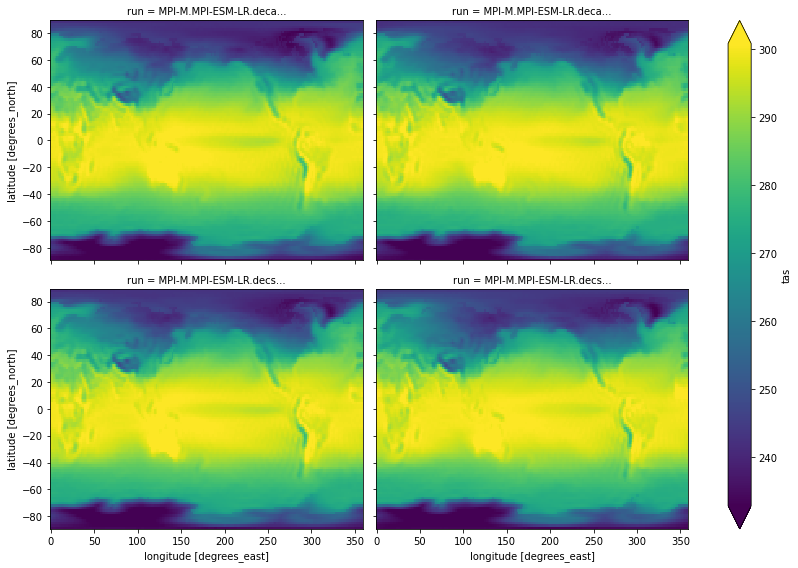

In [70]:
# plot one target timestep: Feb 93
ds.sel(time="1993-02").squeeze().plot(
    col="run", col_wrap=2, robust=True, figsize=(12, 8)
)

## MPI Grand Ensemble

Max Planck Institute Grand Ensemble (Maher et al. 2019 https://doi.org/10/gf3kgt) cmorized by CMIP5-standards accessible on the DKRZ's MISTRAL disk storage system in `/work/mh1007/CMOR/MPI-GE`.

In [71]:
col_url = "/work/ik1017/Catalogs/mistral-MPI-GE.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

product_id institute    model experiment frequency modeling_realm mip_table  \
0    output1     MPI-M  MPI-ESM  piControl       mon          atmos      Amon   
1    output1     MPI-M  MPI-ESM  piControl       mon          atmos      Amon   
2    output1     MPI-M  MPI-ESM  piControl       mon          atmos      Amon   
3    output1     MPI-M  MPI-ESM  piControl       mon          atmos      Amon   
4    output1     MPI-M  MPI-ESM  piControl       mon          atmos      Amon   

   ensemble_member variable temporal_subset    version  \
0                1     prsn   310001-319912  v20190123   
1                1     prsn   380001-385012  v20190123   
2                1     prsn   230001-239912  v20190123   
3                1     prsn   280001-289912  v20190123   
4                1     prsn   190001-199912  v20190123   

                                                path  
0  /work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...  
1  /work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...  
2  /work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...  
3  /work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...  
4  /work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...

In [72]:
# example: GMST for three members in historical with all scenarios
cat = col.search(
    variable="tas",
    mip_table="Amon",
    ensemble_member=[1, 50, 100],
    experiment=["historical", "rcp26", "rcp45", "rcp85"],
)

In [73]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": 12 * 20}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'
                
--> There is/are 4 group(s)


In [74]:
dset_dict.keys()

dict_keys(['MPI-M.MPI-ESM.historical.Amon', 'MPI-M.MPI-ESM.rcp26.Amon', 'MPI-M.MPI-ESM.rcp45.Amon', 'MPI-M.MPI-ESM.rcp85.Amon'])

In [75]:
ds = xr.merge(
    [list(dset_dict.values())[0], xr.concat(list(dset_dict.values())[1:], "experiment")]
)

In [76]:
ds["experiment"] = ["RCP2.6", "RCP4.5", "RCP8.5"]

In [77]:
gmst = ds.mean(["lon", "lat"])["tas"]

In [78]:
gmst = gmst.groupby("time.year").mean("time")
del gmst["height"]

Text(0.5, 1.0, 'MPI Grand Ensemble: GMST')

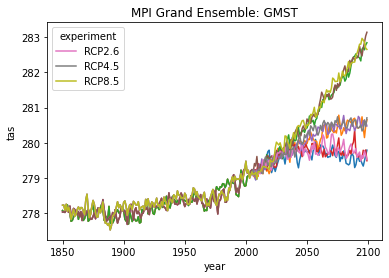

In [79]:
for member in gmst.ensemble_member:
    gmst.sel(ensemble_member=member).plot.line(hue="experiment")
plt.title("MPI Grand Ensemble: GMST")